<a href="https://colab.research.google.com/github/anya765/climate-evidence-synthesis-nlp/blob/main/match_studies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load location data and drop any duplicated places within documents
import pandas as pd

import os
if os.path.exists("/content/"):
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/climate-science") 
    ! pip install cartopy
    ! pip install --no-binary shapely shapely --force
    ! pip install shapely[vectorized]
    ! pip install rioxarray
    ! pip install geopandas

#load location data 
places = pd.read_csv('data/places.csv')                                                                                                                                                                                                                                                                                                                                                                                                                              
places = places.drop_duplicates(["doc_id","geonameid"]) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 3.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 6.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 21.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 24.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 27.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... do

In [ ]:
import numpy as np
def generate_grid_df(degrees):
    '''
    Generate a dataframe with a grid of of cells degrees x degrees
    '''
    LON = np.linspace(-180+degrees*0.5,180-degrees*0.5,int(360/degrees))
    LAT = np.linspace(-90+degrees*0.5,90-degrees*0.5,int(180/degrees))
    lon_df, lat_df = np.meshgrid(LON,LAT)

    return pd.DataFrame({"LAT": lat_df.ravel(), "LON": lon_df.ravel()})
    
grid_df = generate_grid_df(2.5)
grid_df.head()

,LAT,LON
0,-88.75,-178.75
1,-88.75,-176.25
2,-88.75,-173.75
3,-88.75,-171.25
4,-88.75,-168.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline)

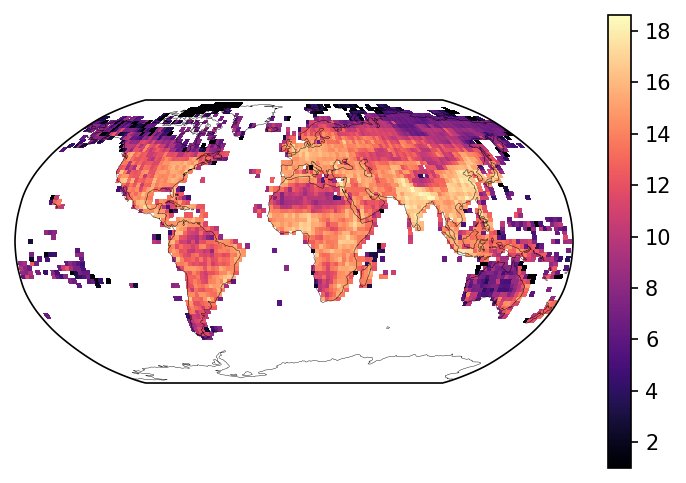

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rioxarray


fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.Robinson())
ax.coastlines(lw=0.2)

#open random population data
rds = rioxarray.open_rasterio("data/gpw_v4_population_count_rev11_2020_1_deg.asc")
rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "population"
pop_df = rds.to_dataframe().reset_index()

#round the grid points up to the grid cell size we have
pop_df['LAT'] = pop_df['y']//2.5*2.5+1.25
pop_df['LON'] = pop_df['x']//2.5*2.5+1.25
pop_df.loc[pop_df['population'].isin([-9999,0]),"population"]=np.NaN
#take the sum of each of these larger grid cells
pop_df = pop_df.groupby(["LAT","LON"])['population'].sum().reset_index()

pop_grid_df = grid_df.merge(pop_df, how="left")
shape = (len(grid_df.LAT.unique()), len(grid_df.LON.unique()))
n = np.log(np.array(pop_grid_df.population)).reshape(shape)

mesh=ax.pcolormesh(
    grid_df.LON.unique(), 
    grid_df.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma'),
    vmin=1,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)

In [ ]:
import cartopy.io.shapereader as shpreader
import geopandas
#defne a list of the shapefile definitions we want
shpfiles = [
    dict(resolution='50m', category='cultural', name='admin_0_countries'),
    dict(resolution='10m', category='cultural', name='admin_1_states_provinces'),
    dict(resolution='10m', category='physical', name='geography_regions_polys'),
    dict(resolution='10m', category='physical', name='geography_marine_polys')
    #"data/gadm36_1.shp"
]

In [ ]:
import shapely.vectorized
import warnings
import time


def match_shp_grid(shpfiles, grid_df, shp_grid_df, degrees):
    #download the shapefiles and combine into one large geopandas dataframe
    shp_df  = None
    for shpfilename in shpfiles:
        print(f"reading shapefile {shpfilename}")
        if shp_df is None:
            shp_df = geopandas.read_file(shpreader.natural_earth(**shpfilename))
        else:
            shp_df = shp_df.merge(geopandas.read_file(shpreader.natural_earth(**shpfilename)),how="outer")
        time.sleep(10) 
    shp_grid = []

    yv, xv = np.meshgrid(grid_df.LAT.unique(), grid_df.LON.unique())
    for i, place in shp_df.iterrows(): 
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            inplace = shapely.vectorized.contains(place.geometry, xv, yv)
        idx = np.argwhere(inplace)
        number_cells = idx.size/2
        if number_cells == 0:
            c = np.array(place.geometry.centroid)
            lon = c[0]//degrees*degrees+degrees*0.5
            lat = c[1]//degrees*degrees+degrees*0.5
            da_df = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)]
            shp_grid.append({"shpfile_id": i, "grid_df_id": da_df.index[0]})
        else:
            for point in idx:
                lon = grid_df.LON.unique()[point[0]]
                lat = grid_df.LAT.unique()[point[1]]
                da_df = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)]
                shp_grid.append({"shpfile_id": i, "grid_df_id": da_df.index[0]}) 

    shp_grid_df = pd.DataFrame.from_dict(shp_grid)

    return shp_df, shp_grid_df 

shp_grid_df = pd.DataFrame()
    
shp_df, shp_grid_df = match_shp_grid(shpfiles, grid_df, shp_grid_df, 2.5)

shp_grid_df.head()

reading shapefile {'resolution': '50m', 'category': 'cultural', 'name': 'admin_0_countries'}


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


reading shapefile {'resolution': '10m', 'category': 'cultural', 'name': 'admin_1_states_provinces'}


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


reading shapefile {'resolution': '10m', 'category': 'physical', 'name': 'geography_regions_polys'}


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_geography_regions_polys.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


reading shapefile {'resolution': '10m', 'category': 'physical', 'name': 'geography_marine_polys'}


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_geography_marine_polys.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: ShapelyDeprecationWarning: The array interface is d

,shpfile_id,grid_df_id
0,0,4114
1,0,3971
2,0,4115
3,0,3972
4,0,4116


In [ ]:
feature_mapping = {
    "ADM1": ["Admin-1 scale rank", "Admin-1 aggregation", "Admin-1 minor island"],
    "PCLI": ["Admin-0 country"],
    'MTS': ['Range/mtn'],
    'PLAT': ['Plateau'],
    'PLN': ['Plain'],
    'DSRT': ['Desert'],
    'OCN': ['ocean'],
    'SEA': ['sea', 'bay'],
    'GULF': ['gulf', 'bay'],
    'BAY': ['gulf', 'bay'],
    'CHN': ['channel'],
    'BSNU': ['basin']
}

In [ ]:
for fcode in places.feature_code.unique():
    if fcode not in feature_mapping:
        feature_mapping[fcode] = []

In [ ]:
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Altay", case=False)),"name"] = "Altay"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Appalach", case=False)),"name"] = "Appalachian Mountains"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("cant", case=False)),"name"] = "Cordillera Cantábrica"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Dabie", case=False)),"name"] = "Dabie Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("EASTERN GHATS", case=False)),"name"] = "Eastern Ghāts"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("WESTERN GHATS", case=False)),"name"] = "Western Ghāts"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("kunlun", case=False)),"name"] = "Kalakunlun Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("LEN MOUNTAIN", case=False)),"name"] = "Kölen"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Taihang Mts.", case=False)),"name"] = "Taihang Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Tatra Mts.", case=False)),"name"] = "Tatry"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("TIAN SHAN", case=False)),"name"] = "Tien Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("andes", case=False)),"name"] = "Andes Mountains"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("HINDU KUSH", case=False)),"name"] = "Hindū Kush"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Marrah Mts", case=False)),"name"] = "Jabal Marrah"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Lebanon", case=False)),"name"] = "Mount Lebanon"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("KARAKORAM RA", case=False)),"name"] = "Karakorum Shan"

shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Negev", case=False)), "name"] = "Negev"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Atacama", case=False)), "name"] = "Atacama Desert"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("CHIHUAHUAN DESERT", case=False)), "name"] = "Chihuahua Desert"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Lut desert", case=False)), "name"] = "God-e Lut"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("TAKLIMAKAN DESERT", case=False)), "name"] = "Takla Makan Desert"

shp_df.loc[
    (shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("cumberland", case=False)),["name","featurecla"]
] = ["Cumberland Plateau", "Plain"]
shp_df.loc[
    (shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("colorado", case=False)),["name","featurecla"]
] = ["San Francisco Plateau", "Plain"]
shp_df.loc[(shp_df["featurecla"]=="Plain") & (shp_df["name"].str.contains("gange", case=False)),"name"] = "Gangetic Plain"
shp_df.loc[(shp_df["featurecla"]=="Plain") & (shp_df["name"].str.contains("north china", case=False)),"name"] = "Huanghuai Pingyuan"

shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("mongol", case=False)), "name"] = "Nei Mongol Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("deccan", case=False)), "name"] = "Deccan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("chota", case=False)), "name"] = "Chota Nāgpur Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("loess", case=False)), "name"] = "Huangtu Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("khorat", case=False)), "name"] = "Khorat Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("tibet", case=False)), "name"] = "Qing Zang Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("polar", case=False)), "name"] = "South Polar Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("YUNGUI", case=False)), "name"] = "Yungui Gaoyuan"

places["place_name"] = places["place_name"].str.lower().str.replace("mts.","mountains") 
shp_df["name"] = shp_df["name"].str.lower().str.replace("mts.","mountains") 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
#start off with an empty dataframe
shp_df_matches = pd.DataFrame()

#decide the grid box size
degrees = 2.5

#look through the feature type dictionary we had before
for place_key, shpfile_keys in feature_mapping.items():
    
    #get all the places and all the shapes
    feature_places = places.loc[places["feature_code"]==place_key]
    feature_shapes = shp_df.loc[shp_df["featurecla"].isin(shpfile_keys)]
    
    #loop through the places
    for place, group in feature_places.groupby("place_name"):
        if not shpfile_keys:
            shp_id = None 
            lon = group.lon.values[0]//degrees*degrees+degrees*0.5
            lat = group.lat.values[0]//degrees*degrees+degrees*0.5
            grid_df_ids = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)].index

        else:
            place_shapes = pd.DataFrame()
            if feature_shapes["gn_id"].sum() > 0:
                place_shapes = feature_shapes.loc[
                    (feature_shapes["gn_id"]==group.geonameid.values[0])
                ]
            if place_shapes.shape[0]==0 and place_key=="PCLI":
                place_shapes = feature_shapes.loc[
                    feature_shapes["ADM0_A3"] == group.country_predicted.values[0]
                ]
            if place_shapes.shape[0]==0:       
                place_shapes = feature_shapes.loc[
                    (feature_shapes.name == place)
                ]    

            if place_shapes.shape[0]==0:
                continue 
            else:
                shp_id = place_shapes.index[0]
                grid_df_ids = shp_grid_df.loc[
                    (shp_grid_df["shpfile_id"]==shp_id),
                    "grid_df_id"
                ]
        #each document with this place -> add a row for each grid cell index matching the place
        for did in group.doc_id.unique():
            shp_df_matches = pd.concat([
                shp_df_matches,
                pd.DataFrame.from_dict({
                    "grid_df_id": grid_df_ids,
                    "doc_id": [did] * len(grid_df_ids),
                    "shp_id": [shp_id] * len(grid_df_ids),
                    "place": place
                })
            ])
            
            
print(shp_df_matches.shape)
shp_df_matches.head()

(816477, 4)


,grid_df_id,doc_id,shp_id,place
1494,6562,1448655.0,176,arab republic of egypt
1495,6706,1448655.0,176,arab republic of egypt
1496,6850,1448655.0,176,arab republic of egypt
1497,6994,1448655.0,176,arab republic of egypt
1498,6563,1448655.0,176,arab republic of egypt


In [ ]:
shp_df_matches.to_csv("data/shp_df_matches.csv",index=False)

In [ ]:
grid_df.reset_index().to_csv("data/grid_df.csv", index=False)